In [2]:
import os
import numpy as np
from dnnbrain.dnn.core import Stimulus
from dnnbrain.utils.util import gen_dmask
from dnnbrain.dnn import models as db_models
import torch.nn as nn
import torch
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
from dnnbrain.io.fileio import ActivationFile
from activation_PSI import Dnn_act, sparseness

In [5]:
# specify custom paremeters
root = os.getcwd()  # root directory of analysis
net_model = 'AlexNet'  # ['AlexNet', 'Vgg11']

stim_path = os.path.join(root, 'imagenet.stim.csv') # make sure to change the path in [dataset].stim.csv to the local directory of the dataset 

In [6]:
# result path of the specified net
net = net_model.lower() + '_relu_deactivated'
net_dir = os.path.join(root, net)
if os.path.exists(net_dir) is False:
    os.mkdir(net_dir)

# Load DNN, stimuli and define ablated models
dnn = eval('db_models.{}()'.format(net_model))  # load DNN
stimuli = Stimulus()
stimuli.load(stim_path) # load stimuli

# generate DNN mask
layer_name = [dnn.layers[i] for i in range(len(dnn.layers)) if dnn.layers[i].split('_')[-1] == 'relu']
dmask = gen_dmask(layer_name)  

# save path
out_dir = os.path.join(net_dir,'dnn_activation')
if os.path.exists(out_dir) is False:
    os.makedirs(out_dir)

out_path = os.path.join(out_dir, '{0}_imagenet.act.h5'.format(net.lower()))

In [7]:
# ReLU-deactivate model
def norelu_model(dnn):
    class Deact_ReLU(nn.Module):
        def __init__(self):
            super(Deact_ReLU, self).__init__()
        
        def forward(slef, x):
            return x

    def replace_relu_to_none(model):
        for child_name, child in model.named_children():
            if isinstance(child, nn.ReLU):
                setattr(model, child_name, Deact_ReLU())
            else:
                replace_relu_to_none(child)
    
    replace_relu_to_none(dnn.model)

In [ ]:
# prepare model
norelu_model(dnn)    
# extract activation
activation = dnn.compute_activation(stimuli, dmask, 'mean', cuda=True)
# save act
activation.save(out_path)

In [7]:
# load activation
dnnact_alllayer = ActivationFile(out_path).read()
layer_name = list(dnnact_alllayer.keys())

# compute PSI
sp = []
for layer in layer_name:
    dnnact = Dnn_act(dnnact_alllayer[layer], stim_per_cat=50)
    dnnact_catmean = dnnact.cat_mean_act()[0][:, :, 0]
    dnnact_catmean_z = np.nan_to_num(stats.zscore(dnnact_catmean, 0))

    # PSI
    sparse_p = sparseness(dnnact_catmean_z.T, type='s', norm=True)
    sp.append(np.squeeze(sparse_p))    
    print('{0} done'.format(layer))

sp_median = np.array([np.nanmedian(sp[i]) for i in range(len(sp))])

conv1_relu done
conv2_relu done
conv3_relu done
conv4_relu done
conv5_relu done
fc1_relu done
fc2_relu done


Text(0, 0.5, 'PSI')

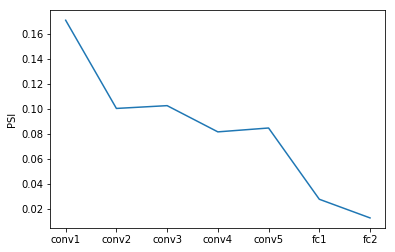

In [8]:
# plot Fig 3F
plt.plot([layer.split('_')[0] for layer in layer_name], sp_median, c='tab:blue')
plt.ylabel('PSI')

**Figure 3. Both the learning process and the gating process play an important role in the formation of the hierarchically-evolved coding scheme in the DCNNs.** (F) Median PSI for objects across layers in the ReLU-deactivated models. X axis: the name of layers along hierarchy; Y axis: the median of PSI.